In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Read in network embedding and price labels

In [33]:
# Network embedding generated by GLACE
ps = pd.read_pickle('GLACE/emb/glace_cora_ml_embedding_first-order.pkl')
len(ps["mu"])

974

In [34]:
# Example of the content of the network embedding for node 2.
ps["mu"][2]

array([ 1.1219455 ,  0.8957876 , -1.0212011 ,  0.9573404 ,  1.2778492 ,
        1.1782261 , -0.8505197 ,  1.0828797 ,  0.66093516,  1.0573201 ,
        0.9836294 ,  1.1308503 , -0.620148  , -1.3031708 , -0.75431705,
       -0.6160234 , -1.1136093 , -0.9388194 , -0.9545261 , -1.0572796 ,
        1.2893603 , -0.749675  ,  0.5449898 ,  1.1955999 ,  1.0922259 ,
        1.2448739 ,  1.1517192 ,  0.9952309 , -1.2936085 , -1.3820841 ,
        1.1183423 , -1.1370598 ,  1.0901617 , -1.2930392 ,  1.1508017 ,
        0.7545409 , -1.0092317 , -0.8983233 , -0.8680123 , -0.79145205,
        1.194396  ,  1.0899092 ,  1.0760761 ,  1.2668289 , -1.2362025 ,
       -0.7802969 ,  1.2225193 , -0.8764839 ,  0.8847276 , -1.3238096 ,
       -0.6570203 ,  1.0390604 ,  0.69118446,  0.06309837, -1.3174437 ,
        1.1343174 , -0.516103  , -1.4234776 , -0.5350549 ,  1.3673124 ,
       -0.69810915,  1.2048788 , -1.3479466 ,  0.9477263 ], dtype=float32)

In [35]:
labels = pd.read_csv("price_label.csv")
labels

,id,price
0,0,221900.0
1,1,538000.0
2,2,180000.0
3,3,604000.0
4,4,510000.0
...,...,...
969,969,291000.0
970,970,199950.0
971,971,553500.0
972,972,189950.0


## Preprocessing
The embedding file is a dictionary file, this needs to be converted into a right format for the ML model to be able to train on it.
1) Can convert the training data to a numpy array.
2) Can constructuct a new dataframe which it would use.

In [54]:
# Change the code to make it more generalizable to take 20% as a test set.
X_train =  np.array([np.array(ps['mu'][k]) for k in range(0, len(ps['mu']) - 200)])
X_test = np.array([np.array(ps['mu'][k]) for k in range(len(ps['mu']) - 200, len(ps['mu']))])

In [55]:
y_train =  np.array([np.array(labels['price'][k]) for k in range(0, len(labels['price']) - 200)])
y_test = np.array([np.array(labels['price'][k]) for k in range(len(labels['price']) - 200, len(labels['price']))])

Investigate the distribution of the target variable.

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 531495.17 and sigma = 355788.88



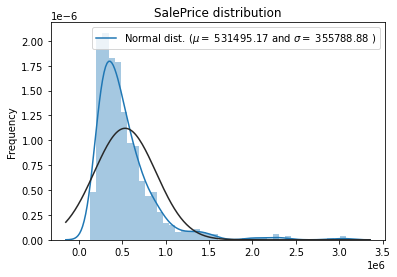

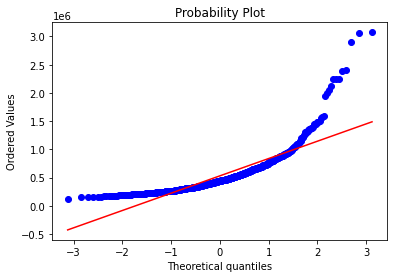

In [38]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 

sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

The distribution of the target variable is skewed. 

Perform log-transformation of the target variable in the training and test set.

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 13.03 and sigma = 0.53



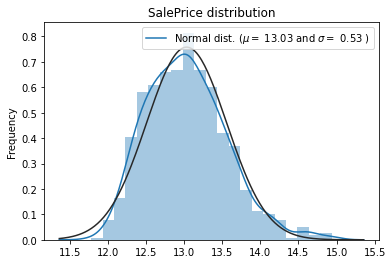

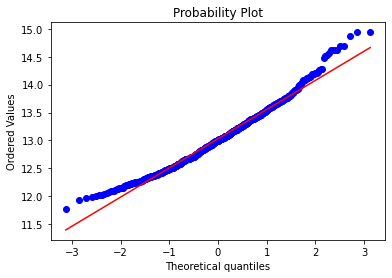

In [39]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.98 and sigma = 0.49



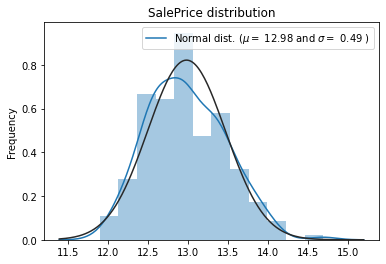

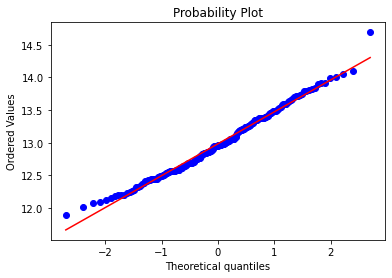

In [40]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_test = np.log1p(y_test)

#Check the new distribution 
sns.distplot(y_test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_test, plot=plt)
plt.show()

## Modeling with network embedding - GLACE

In [59]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)


LinearRegression()

I should check for the following conditions to check what isd going wrong with the prediction of the models:
1) Class imbalance, uneven distirbution. Need to plot the distribution and ptoentially nromalize it. -- Lognormalizing this does have a signifant increase in performance of the model too.
2) High non-linearitty, then i need to use another model to see if it has the same consequence -- IT SEEMS LIKE THIS WAS THE CASE!
3) Overfitting, seems weird. Could check by taking a larger dataset or using regularization.

In [60]:
linreg.predict(X_test)

array([ 594944.,  472064.,  962560.,  621568., 1234944.,  394240.,
        638976.,  317440.,  335872.,  376832.,  670720.,  425984.,
        559104.,  366592.,  627712.,  373760.,  560128., 1296384.,
        317440.,  105472.,  214016.,  737280.,  181248.,  262144.,
        345088., 1139712.,  358400.,  328704.,  206848.,  783360.,
        265216.,  434176.,  579584.,  632832.,  358400.,  500736.,
        631808.,  357376.,  305152.,  335872.,  393216.,  553984.,
        328704.,  483328.,  940032.,  524288.,  466944.,  626688.,
        590848.,  254976.,  349184.,  334848.,  458752.,  430080.,
        334848.,  549888.,  283648.,  286720.,  475136.,  968704.,
        273408.,  121856.,  415744.,  453632.,  789504.,  459776.,
        211968.,  605184.,  292864.,  366592.,  482304.,  609280.,
        398336.,  783360.,  792576.,  943104.,  798720.,  245760.,
        308224.,  392192.,   37888.,  368640.,  336896.,  488448.,
        731136., 1104896., 1033216.,  688128.,  411648.,  2007

In [58]:
linreg.score(X_test, y_test)

0.6752639222497008

In [61]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linreg, X_train, y_train, cv=5)
scores.mean()

0.6918768630691658

In [62]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.5755860657072109

In [63]:
scores = cross_val_score(XGBR, X_train, y_train, cv=5)
scores.mean() # Need to check if this is normal without hyperparameter tuning etc. Check this in contrast to using a classical approach to estimating the model performance.
# Note also that this is a very small dataset of 1000 instances, it has trained on approx 800 and tests on 200, so it is somewhat normal that the score is low.

0.2822052731001218

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
y_pred = rf.predict(X_test)
y_pred

array([2.66082112, 2.65075922, 2.66081694, 2.67670072, 2.69711299,
       2.66057006, 2.65924309, 2.6014981 , 2.64369043, 2.61331303,
       2.64949927, 2.65166831, 2.60795043, 2.64687706, 2.65502297,
       2.62671702, 2.64889124, 2.70651545, 2.63080222, 2.63979406,
       2.61453986, 2.6531438 , 2.63784814, 2.64299066, 2.61635096,
       2.66641692, 2.62975576, 2.6202645 , 2.60739327, 2.66891458,
       2.61030646, 2.63845859, 2.64404877, 2.64411208, 2.62651855,
       2.61497977, 2.66646912, 2.59560615, 2.65440612, 2.65365435,
       2.61419781, 2.6098049 , 2.60487118, 2.61577278, 2.67334763,
       2.64882756, 2.62878107, 2.67938282, 2.63032663, 2.66596669,
       2.59630676, 2.63539316, 2.59525419, 2.61843083, 2.61256794,
       2.637948  , 2.62896384, 2.61515382, 2.64392614, 2.64981861,
       2.60337249, 2.58149335, 2.65874771, 2.66967468, 2.6752018 ,
       2.62591783, 2.60785   , 2.63413021, 2.64560222, 2.64542452,
       2.63472954, 2.66421192, 2.66539814, 2.68609511, 2.66066

In [28]:
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores.mean()

0.5341764930130524

In [27]:
mse = mean_squared_error(y_test, y_pred)
mse

107.22547883637122

## Modelling without network embedding - raw features

Feature engineering is not included yet with regards to geospatial information like amount of houses in certain proximity.

In [71]:
base_df = pd.read_csv("BaseKC_data.csv")
base_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,index
0,7129300520,221900.0,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.50,...,0.000000,0.893939,47.5112,-122.257,0.161934,0.005742,0.0,0.818182,0.400000,0
1,6414100192,538000.0,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.50,...,0.988089,0.626263,47.7210,-122.319,0.222165,0.008027,0.0,1.000000,0.266667,1
2,5631500400,180000.0,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.50,...,0.000000,0.136364,47.7379,-122.233,0.399415,0.008513,1.0,0.090909,0.800000,2
3,2487200875,604000.0,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.00,...,0.000000,0.681818,47.5208,-122.393,0.165376,0.004996,0.0,1.000000,0.266667,3
4,1954400510,510000.0,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.50,...,0.000000,0.368687,47.6168,-122.045,0.241094,0.007871,1.0,0.090909,0.566667,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,7437100570,291000.0,0.121212,0.31250,0.118491,0.003516,0.4,0.0,0.0,0.75,...,0.000000,0.186869,47.3492,-122.030,0.251420,0.006660,0.0,0.636364,0.666667,995
970,8856004730,199950.0,0.060606,0.34375,0.098113,0.012356,0.2,0.0,0.0,0.50,...,0.000000,0.000000,47.2786,-122.250,0.156772,0.006144,0.0,0.727273,0.533333,996
971,3856902996,553500.0,0.060606,0.12500,0.042264,0.001102,0.0,0.0,0.0,0.50,...,0.000000,0.525253,47.6707,-122.328,0.155051,0.002698,0.0,0.636364,0.100000,997
972,1442800370,189950.0,0.060606,0.12500,0.055849,0.002222,0.0,0.0,0.0,0.50,...,0.000000,0.186869,47.3738,-122.057,0.180864,0.003130,1.0,0.272727,0.466667,998


In [72]:
from sklearn.model_selection import train_test_split
X = base_df.drop(["price"], axis=1)
y = base_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.predict(X_test)
linreg.score(X_test, y_test)


0.7010530271972233

In [68]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.720580441788542

In [69]:
from sklearn.model_selection import cross_val_score
for model in [linreg, XGBR]:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model, scores.mean())

LinearRegression() 0.672699177319112
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 0.7788071649027655


Predictions with log normalized target variables

In [74]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [75]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.predict(X_test)
linreg.score(X_test, y_test)

0.7112354480497862

In [76]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.7974338493242606

In [77]:
from sklearn.model_selection import cross_val_score
for model in [linreg, XGBR]:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model, scores.mean())

LinearRegression() 0.7869547369505678
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 0.8481229224833513
